# Телеком

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Описание услуг:
1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

## План проекта:

1) Исследование данных
* Изучение датасетов;
* Проверка на дубликаты и пропуски;
* Проверка типов данных.

2) Подготовка данных
* Объединение таблиц;
* Предобработка пропусков и дубликатов;
* Изменение типов данных.

3) Исследовательский анализ данных.

4) Подготовка признаков для модели.

5) Построение моделей: {LGBMClassifier, CatBoostClassifier, RandomForrestClassifier}. Подборка гиперпараметров и выбор наилучшей модели.

6) Проверка лучшей модели на тестовой выборке.

7) Вывод.

## Вопросы:

1) При объедененнии таблиц в одну, будет много пропусков из-за разного количества информации в таблицах. Что делать с этими клиентами и пропусками? И есть ли смысл все объединять?

2) В качестве целевого признака будет столбец `EndDate` как я понял. Поэтому, лучше всего сделать отдельный столбец с 1 и 0? Так как в столбце есть даты.

3) В качестве кодироавания лучше всего использовать Ordinal Encoding?

Пока вопросы такие)

## Общий анализ

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

# ML
from sklearn.metrics import (auc, roc_curve, roc_auc_score, accuracy_score, 
                             precision_score, recall_score, confusion_matrix)
from sklearn.model_selection import (train_test_split, 
                                     GridSearchCV, RandomizedSearchCV)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

rnd_state = 120922

In [2]:
try:
    contract = pd.read_csv("contract.csv")
    personal = pd.read_csv("personal.csv")
    internet = pd.read_csv("internet.csv")
    phone = pd.read_csv("phone.csv")
except:
    contract = pd.read_csv("/datasets/final_provider/contract.csv")
    personal = pd.read_csv("/datasets/final_provider/personal.csv")
    internet = pd.read_csv("/datasets/final_provider/internet.csv")
    phone = pd.read_csv("/datasets/final_provider/phone.csv")    

In [3]:
def inf(data):
    print("Анализ датасета:")
    print()
    print("Общая информация:")
    print()
    print(data.info())
    print()
    print("-"*50)
    print()
    print("Количество пропусков:")
    print(data.isna().sum())
    print()
    print("-"*50)
    print()
    print("Количество дубликатов:")
    print(data.duplicated().sum())
    print()
    print("-"*50)
    print()
    return data.head(10)

### Информация о `contract`

In [4]:
inf(contract)

Анализ датасета:

Общая информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None

--------------------------------------------------

Количество пропусков:
customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

--------------------------------------------------

Количество 

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95


### Информация о `personal`

In [5]:
inf(personal)

Анализ датасета:

Общая информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None

--------------------------------------------------

Количество пропусков:
customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

--------------------------------------------------

Количество дубликатов:
0

--------------------------------------------------



,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


### Информация о `internet`

In [6]:
inf(internet)

Анализ датасета:

Общая информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None

--------------------------------------------------

Количество пропусков:
customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

--------------------------------------------------

Количество дубликатов:
0

-------

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


### Информация о `phone`

In [7]:
inf(phone)

Анализ датасета:

Общая информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None

--------------------------------------------------

Количество пропусков:
customerID       0
MultipleLines    0
dtype: int64

--------------------------------------------------

Количество дубликатов:
0

--------------------------------------------------



,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


### Вывод:
 В таблицах не обнаружены пропуски и дубликаты. Однако в датасете `contract` у признаков неправильный тип данных:
 - TotalCharges должен быть float;
 - BeginDate в формате даты;
 
В датасетах `phone` и `internet` записей меньше, чем в других. При объеденении таблиц могут возникнуть пропуски

## Подготовка данных

In [8]:
df = (contract
   .merge(personal, how="left", on="customerID")
   .merge(phone, how="left", on="customerID")
   .merge(internet, how="left", on="customerID"))

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  MultipleLines     6361 non-null   object 
 13  InternetService   5517 non-null   object 
 14  OnlineSecurity    5517 non-null   object 
 15  OnlineBackup      5517 non-null   object 
 16  DeviceProtection  5517 non-null   object 


Так как пропуски обусловленные тем что, клиенты не пользовались данными услугами, то заменим пропуски на 'No'.

In [10]:
df = df.fillna('No')

In [11]:
df.duplicated().sum()

0

Дубликатов не обнаружено

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  MultipleLines     7043 non-null   object 
 13  InternetService   7043 non-null   object 
 14  OnlineSecurity    7043 non-null   object 
 15  OnlineBackup      7043 non-null   object 
 16  DeviceProtection  7043 non-null   object 


Создадим отдельный столбец, где: 
* 0 - клиент не ушел;
* 1 - клиент ушел;

In [13]:
df.loc[df['EndDate'] != 'No', 'Leave'] = 1
df.loc[df['EndDate'] == 'No', 'Leave'] = 0  
df['Leave'] = df['Leave'].astype(int)

In [14]:
# преобразуем тип данных полей с датой
df['BeginDate'] = pd.to_datetime(df['BeginDate'])
# Где `No`  заполним дату на момент выгрузки
df.loc[df.EndDate == 'No', 'EndDate'] = '2020-02-01'
df['EndDate'] = pd.to_datetime(df['EndDate'])
# вычисляем длительность действия договора в днях
df['UsageTime'] = (df['EndDate'] - df['BeginDate']).dt.days

In [15]:
df[df['TotalCharges']!=' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Leave,UsageTime
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,No,DSL,No,Yes,No,No,No,No,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.5,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,1,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,0,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,No,Fiber optic,No,No,No,No,No,No,1,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,1990.5,Male,0,...,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,0,730
7039,2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7362.9,Female,0,...,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,0,2191
7040,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346.45,Female,0,...,No,DSL,Yes,No,No,No,No,No,0,337
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.6,Male,1,...,Yes,Fiber optic,No,No,No,No,No,No,1,123


В `TotalCharges` есть 11 пропусков. Момент регистрации совпадает с датой выгрузки, следовательно это новые клиенты. Уберем их из датасета

In [16]:
df = df[df['TotalCharges']!=' ']
df['TotalCharges'] = df['TotalCharges'].astype(float)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   gender            7032 non-null   object        
 9   SeniorCitizen     7032 non-null   int64         
 10  Partner           7032 non-null   object        
 11  Dependents        7032 non-null   object        
 12  MultipleLines     7032 non-null   object        
 13  InternetService   7032 non-null   object        
 14  OnlineSecurity    7032 n

### Вывод:

* Все датасеты объедены в один большой;
* Дубликатов не обнаружено;
* Полученные пропуски, в результате объеденения таблиц, заменены на `No`, так как клиенты не использовали данные услуги;
* В `TotalCharges` были пропуски в результате того, что присутствовали новые люди на момент выгрузки;
* Созданы два новых столбца: бинарный признак ухода клиента и количество дней между заключением договора и его расторжением (или на момент выгрузки, если клиент не ушел);
* Изменены типы данных.

## Исследовательский анализ данных

In [18]:
df.describe()

,MonthlyCharges,TotalCharges,SeniorCitizen,Leave,UsageTime
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,64.798208,2283.300441,0.162400,0.265785,987.538538
std,30.085974,2266.771362,0.368844,0.441782,747.153663
min,18.250000,18.800000,0.000000,0.000000,30.000000
25%,35.587500,401.450000,0.000000,0.000000,275.000000
50%,70.350000,1397.475000,0.000000,0.000000,883.000000
75%,89.862500,3794.737500,0.000000,1.000000,1676.000000
max,118.750000,8684.800000,1.000000,1.000000,2191.000000


<AxesSubplot:>

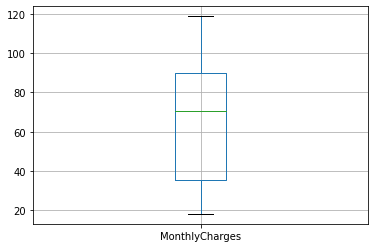

In [19]:
df.boxplot(column='MonthlyCharges')

<AxesSubplot:>

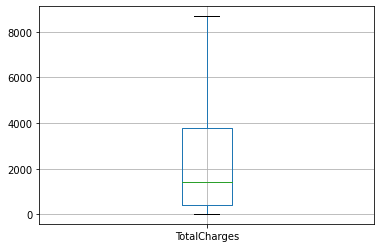

In [20]:
df.boxplot(column='TotalCharges')

Выбросов не наблюдается

In [21]:
gone_data = df[df["Leave"] != 0]

[Text(0.5, 0, 'Ушедшие клиенты')]

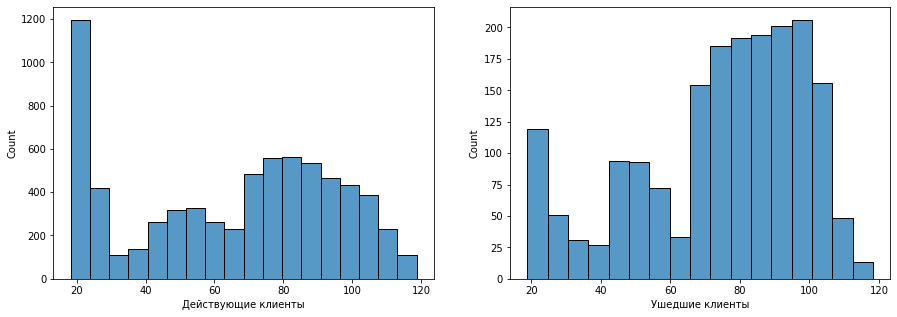

In [22]:
fig, ax = plt.subplots(1 ,2, figsize=(15,5))
sns.histplot(data=df["MonthlyCharges"], ax=ax[0])
sns.histplot(data=gone_data['MonthlyCharges'], ax=ax[1])
ax[0].set(xlabel='Действующие клиенты')
ax[1].set(xlabel='Ушедшие клиенты')

По графикам можно заметить, что чаще уходят клиенты у которых ежемесячные траты намного выше (Стоимость в месяц от 60 до 110)

[Text(0.5, 0, 'Ушедшие клиенты')]

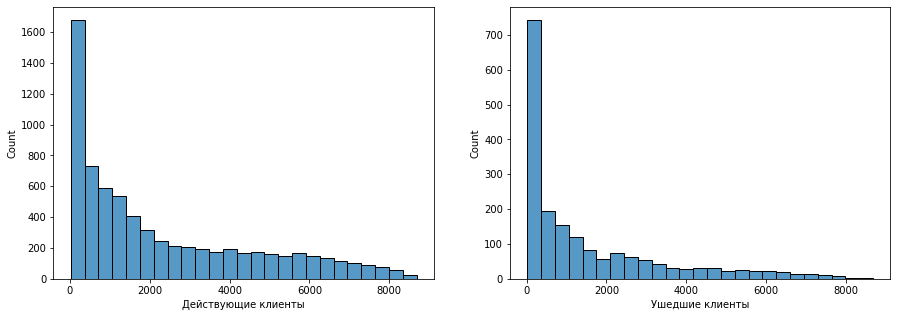

In [23]:
fig, ax = plt.subplots(1 ,2, figsize=(15,5))
sns.histplot(data=df["TotalCharges"], ax=ax[0])
sns.histplot(data=gone_data['TotalCharges'], ax=ax[1])
ax[0].set(xlabel='Действующие клиенты')
ax[1].set(xlabel='Ушедшие клиенты')

Общая оплата показывает, что уходят клиенты, которые платили не так долго (по сроку пользования тарифом)

In [24]:
df["Type"].value_counts()

Month-to-month    3875
Two year          1685
One year          1472
Name: Type, dtype: int64

<AxesSubplot:xlabel='Type', ylabel='Count'>

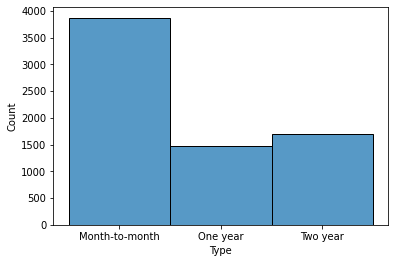

In [25]:
sns.histplot(data=contract["Type"])

Большая часть клиентов используют месячную подписку 

In [26]:
df['gender'].value_counts()

Male      3549
Female    3483
Name: gender, dtype: int64

Количество мужчин и женщин почти равное

In [27]:
df['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1604
Bank transfer (automatic)    1542
Credit card (automatic)      1521
Name: PaymentMethod, dtype: int64

<AxesSubplot:xlabel='PaymentMethod', ylabel='Count'>

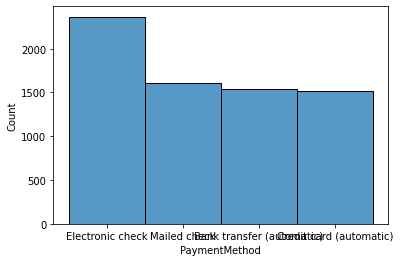

In [28]:
sns.histplot(data=df["PaymentMethod"])

Наиболее популярный метод оплтаы является Electronic check

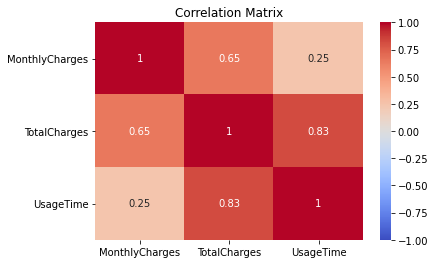

In [29]:
numeric_features = ['MonthlyCharges','TotalCharges','UsageTime']
sns.heatmap(df[numeric_features].corr(),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

По матрице видно, что Общие траты сильно зависят от времени, когда клиент пользуется услугами. При обучении моделей, необходимо убрать данный пункт в связи с высокой корреляцией.

## Вывод:

* Перестают пользоваться услугами компании те клиенты, у которых месячные траты большие;
* Данные клиенты уходят в первые месяцы;
* Наиболее используемый метод оплаты - электронный чек;
* Месячная подписка является самой используемой среди клиентов;
* Гендерное распределение сбалансировано;
* Найдена сильная корреляция между общими тратами и времени использования услуг

## Подготовка признаков для модели

Могут быть удалены следующие столбцы:

1) Даты BeginDate и EndDate.

2) Gender, customerID - не несёт полезной информации

3) TotalCharges - мультиколлинеарный по отношению к UsageTime

In [30]:
df.drop(columns=['customerID','BeginDate', 'EndDate', 'gender', 'TotalCharges'], inplace=True)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7032 non-null   object 
 1   PaperlessBilling  7032 non-null   object 
 2   PaymentMethod     7032 non-null   object 
 3   MonthlyCharges    7032 non-null   float64
 4   SeniorCitizen     7032 non-null   int64  
 5   Partner           7032 non-null   object 
 6   Dependents        7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Leave             7032 non-null   int64  
 16  UsageTime         7032 non-null   int64  


In [32]:
cat_features = list(df.columns)
cat_features.remove("Leave")
cat_features.remove("UsageTime")
cat_features.remove("MonthlyCharges")
cat_features

['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies']

In [33]:
numeric_features = ['MonthlyCharges','UsageTime']
numeric_features

['MonthlyCharges', 'UsageTime']

In [34]:
df[cat_features] = df[cat_features].astype("category")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Type              7032 non-null   category
 1   PaperlessBilling  7032 non-null   category
 2   PaymentMethod     7032 non-null   category
 3   MonthlyCharges    7032 non-null   float64 
 4   SeniorCitizen     7032 non-null   category
 5   Partner           7032 non-null   category
 6   Dependents        7032 non-null   category
 7   MultipleLines     7032 non-null   category
 8   InternetService   7032 non-null   category
 9   OnlineSecurity    7032 non-null   category
 10  OnlineBackup      7032 non-null   category
 11  DeviceProtection  7032 non-null   category
 12  TechSupport       7032 non-null   category
 13  StreamingTV       7032 non-null   category
 14  StreamingMovies   7032 non-null   category
 15  Leave             7032 non-null   int64   
 16  UsageTime         7032 n

In [35]:
df['Leave'].value_counts()

0    5163
1    1869
Name: Leave, dtype: int64

<AxesSubplot:xlabel='Leave', ylabel='Count'>

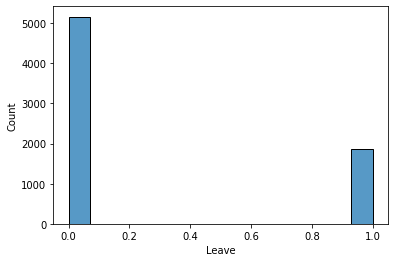

In [36]:
sns.histplot(data=df['Leave'])

Присутствует дисбаланс классов. Учтем при обучении

In [37]:
#One-Hot Enconding
#df_OHE = pd.get_dummies(df, drop_first=True).astype(int)

### Разделение датасета

In [38]:
# разделяем датасет
x_train, x_test, y_train, y_test = train_test_split(df.drop('Leave', axis=1), df['Leave'], test_size=0.25, 
    random_state=rnd_state) 
print('Обучающая выборка: ', x_train.shape, y_train.shape)
print('Тренировочная выборка: ', x_test.shape, y_test.shape)

# масштабируем численные признаки в тренировочной выборке
scaler = StandardScaler()
x_train[numeric_features] = pd.DataFrame(
    scaler.fit_transform(x_train[numeric_features]),
    columns=numeric_features, index=x_train.index
)
# масштабируем численные признаки в тестовой выборке
x_test[numeric_features] = pd.DataFrame(
    scaler.transform(x_test[numeric_features]),
    columns=numeric_features, index=x_test.index)

Обучающая выборка:  (5274, 16) (5274,)
Тренировочная выборка:  (1758, 16) (1758,)


### Кодировка

#### get_dummies

In [39]:
x_train_dummy = x_train[cat_features].copy()
x_test_dummy = x_test[cat_features].copy()

In [40]:
x_train_dummy = pd.get_dummies(x_train_dummy, drop_first=True).astype(int)
x_train_dummy["MonthlyCharges"] = x_train["MonthlyCharges"]
x_train_dummy["UsageTime"] = x_train["UsageTime"]
x_train_dummy

,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen_1,Partner_Yes,Dependents_Yes,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MonthlyCharges,UsageTime
5395,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0.535501,-1.112006
5631,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,-1.329587,-1.193888
2975,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,-0.142259,-1.193888
4076,0,1,1,1,0,0,0,1,0,1,1,0,1,1,1,0,1,0,1.146650,1.544454
6844,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,1,0,0.823590,-0.132109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1053,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,-0.846663,-1.112006
5242,0,0,1,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0.791950,-0.502591
1471,0,0,0,1,0,0,0,1,0,1,1,0,0,0,1,0,1,0,0.790285,-0.048885
1859,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0.680378,0.807518


In [41]:
x_test_dummy = pd.get_dummies(x_test_dummy, drop_first=True).astype(int)
x_test_dummy["MonthlyCharges"] = x_test["MonthlyCharges"]
x_test_dummy["UsageTime"] = x_test["UsageTime"]
x_test_dummy

,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen_1,Partner_Yes,Dependents_Yes,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MonthlyCharges,UsageTime
2421,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,-0.833340,1.462573
3356,0,0,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,-0.468649,-1.153618
1517,1,0,1,0,1,0,0,1,0,1,1,0,1,0,0,0,1,1,1.186616,0.972624
2335,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,-0.303789,-1.112006
3452,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-0.665150,-1.275770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3832,1,0,1,1,0,0,0,1,0,1,0,0,0,1,0,1,1,1,0.457234,0.767248
6522,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,-1.029841,0.441064
3102,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,-0.357077,-1.112006
6794,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,-1.511100,0.441064


#### OHE

In [42]:
ohe = OneHotEncoder(sparse=False)
x_train_ohe = x_train.copy()
x_test_ohe = x_test.copy()

In [43]:
x_train_ohe = ohe.fit_transform(x_train[cat_features])

In [44]:
x_train_ohe

array([[1., 0., 0., ..., 1., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 1., 1., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [45]:
x_test_ohe = ohe.transform(x_test_ohe[cat_features])

In [46]:
x_test_ohe

array([[1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 1., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       [1., 0., 0., ..., 1., 0., 1.]])

#### Ordinal Encoding

In [47]:
oe = OrdinalEncoder()
x_train_oe = x_train.copy()
x_test_oe = x_test.copy()

In [48]:
x_train_oe[cat_features] = oe.fit_transform(x_train[cat_features])

In [49]:
x_train_oe

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,UsageTime
5395,0.0,1.0,1.0,0.535501,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.112006
5631,0.0,0.0,3.0,-1.329587,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.193888
2975,0.0,0.0,3.0,-0.142259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-1.193888
4076,2.0,1.0,1.0,1.146650,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.544454
6844,0.0,0.0,3.0,0.823590,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,-0.132109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1053,0.0,0.0,2.0,-0.846663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.112006
5242,0.0,1.0,2.0,0.791950,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.502591
1471,0.0,0.0,1.0,0.790285,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.048885
1859,0.0,1.0,2.0,0.680378,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.807518


In [50]:
x_test_oe[cat_features] = oe.transform(x_test_oe[cat_features])

In [51]:
x_test_oe

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,UsageTime
2421,0.0,1.0,0.0,-0.833340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.462573
3356,0.0,0.0,3.0,-0.468649,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.153618
1517,1.0,1.0,2.0,1.186616,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.972624
2335,0.0,1.0,3.0,-0.303789,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,-1.112006
3452,0.0,1.0,3.0,-0.665150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.275770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3832,1.0,1.0,1.0,0.457234,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.767248
6522,0.0,0.0,0.0,-1.029841,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.441064
3102,0.0,0.0,2.0,-0.357077,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-1.112006
6794,2.0,0.0,3.0,-1.511100,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.441064


### Вывод:

* Удалены лишние признаки
* Датасет разделен на тренировачную и тестовую выборку
* Кодировка данных с помощью One-Hot Enconding
* Масштабированы признаки в тренировочной и тестовой выборке

## Обучение моделей

### Обучение моделей c Ordinal Enconding

In [52]:
# Оставлены уже подобранные параметры в моделях, так как обучение каждой модели занимает много времени

In [53]:
models_scors = pd.DataFrame(columns = ['model', 'roc_auc'])

#### RandomForrestClassifier

In [54]:
%%time
RF_model = RandomForestClassifier(random_state=rnd_state, class_weight='balanced')

parameters = [{'max_depth': [8],
               'n_estimators': [260]}]

RF_model_gscv = GridSearchCV(RF_model, param_grid=parameters, scoring='roc_auc', 
                   cv=3, verbose=True)
RF_model_gscv.fit(x_train_oe, y_train)

models_scors = models_scors.append({'model' : 'RandomForest_oe',
                     'roc_auc' : round(RF_model_gscv.best_score_,4)}, ignore_index=True)

RF_model_gscv.best_params_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
CPU times: user 3.36 s, sys: 6.48 ms, total: 3.37 s
Wall time: 5.89 s


{'max_depth': 8, 'n_estimators': 260}

#### CatBoostClassifier

In [55]:
%%time
CBC_model = CatBoostClassifier(random_state=rnd_state)

parameters = [{'max_depth': [2],
               'learning_rate': [0.3],
               'n_estimators': [800]}]

CBC_model_gscv = GridSearchCV(CBC_model, param_grid=parameters, scoring='roc_auc', 
                   cv=3, verbose=True, n_jobs=-1)
CBC_model_gscv.fit(x_train_oe, y_train)

models_scors = models_scors.append({'model' : 'CatBoostClassifier_oe',
                     'roc_auc' : round(CBC_model_gscv.best_score_,4)}, ignore_index=True)

CBC_model_gscv.best_params_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
0:	learn: 0.5560828	total: 46.7ms	remaining: 37.3s
1:	learn: 0.5034575	total: 47.4ms	remaining: 18.9s
2:	learn: 0.4699261	total: 48.1ms	remaining: 12.8s
3:	learn: 0.4569556	total: 48.8ms	remaining: 9.71s
4:	learn: 0.4409121	total: 49.5ms	remaining: 7.87s
5:	learn: 0.4267102	total: 50.1ms	remaining: 6.63s
6:	learn: 0.4217246	total: 50.7ms	remaining: 5.74s
7:	learn: 0.4182204	total: 51.3ms	remaining: 5.08s
8:	learn: 0.4152819	total: 52ms	remaining: 4.57s
9:	learn: 0.4119917	total: 52.7ms	remaining: 4.16s
10:	learn: 0.4096086	total: 53.4ms	remaining: 3.83s
11:	learn: 0.4074813	total: 54ms	remaining: 3.55s
12:	learn: 0.4050221	total: 54.6ms	remaining: 3.31s
13:	learn: 0.4010504	total: 55.4ms	remaining: 3.11s
14:	learn: 0.4001480	total: 56ms	remaining: 2.93s
15:	learn: 0.3975180	total: 56.7ms	remaining: 2.78s
16:	learn: 0.3962110	total: 57.4ms	remaining: 2.65s
17:	learn: 0.3950040	total: 58.1ms	remaining: 2.52s
18:	learn: 0.3944600	

{'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 800}

#### LGBMClassifier

In [56]:
%%time
LGBMC_model = LGBMClassifier(random_state=rnd_state, class_weight='balanced')

parameters = [{'max_depth': [3],
               'learning_rate': [0.2],
               'n_estimators': [800]}]

LGBMC_model_gscv = GridSearchCV(LGBMC_model, param_grid=parameters, scoring='roc_auc', 
                   cv=3, verbose=True)
LGBMC_model_gscv.fit(x_train_oe, y_train)

models_scors = models_scors.append({'model' : 'LGBMClassifier_oe',
                     'roc_auc' : round(LGBMC_model_gscv.best_score_,4)}, ignore_index=True)

LGBMC_model_gscv.best_params_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
CPU times: user 11.7 s, sys: 73.1 ms, total: 11.8 s
Wall time: 12.3 s


{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 800}

### Обучение моделей c OneHotEncoder

#### RandomForrestClassifier

In [57]:
%%time
RF_model = RandomForestClassifier(random_state=rnd_state, class_weight='balanced')

parameters = [{'max_depth': [8],
               'n_estimators': [260]}]

RF_model_gscv_ohe = GridSearchCV(RF_model, param_grid=parameters, scoring='roc_auc', 
                   cv=3, verbose=True)
RF_model_gscv_ohe.fit(x_train_ohe, y_train)

models_scors = models_scors.append({'model' : 'RandomForest_ohe',
                     'roc_auc' : round(RF_model_gscv_ohe.best_score_,4)}, ignore_index=True)

RF_model_gscv_ohe.best_params_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
CPU times: user 2.79 s, sys: 38.5 ms, total: 2.83 s
Wall time: 5.5 s


{'max_depth': 8, 'n_estimators': 260}

#### CatBoostClassifier

In [58]:
%%time
CBC_model = CatBoostClassifier(random_state=rnd_state)

parameters = [{'max_depth': [2],
               'learning_rate': [0.3],
               'n_estimators': [800]}]

CBC_model_gscv_ohe = GridSearchCV(CBC_model, param_grid=parameters, scoring='roc_auc', 
                   cv=3, verbose=True, n_jobs=-1)
CBC_model_gscv_ohe.fit(x_train_ohe, y_train)

models_scors = models_scors.append({'model' : 'CatBoostClassifier_ohe',
                     'roc_auc' : round(CBC_model_gscv_ohe.best_score_,4)}, ignore_index=True)

CBC_model_gscv_ohe.best_params_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
0:	learn: 0.5560828	total: 789us	remaining: 631ms
1:	learn: 0.5118754	total: 1.58ms	remaining: 631ms
2:	learn: 0.4875330	total: 2.37ms	remaining: 628ms
3:	learn: 0.4675363	total: 3.04ms	remaining: 605ms
4:	learn: 0.4612784	total: 3.69ms	remaining: 587ms
5:	learn: 0.4498490	total: 4.32ms	remaining: 572ms
6:	learn: 0.4466533	total: 4.93ms	remaining: 559ms
7:	learn: 0.4445879	total: 5.58ms	remaining: 553ms
8:	learn: 0.4413996	total: 6.3ms	remaining: 554ms
9:	learn: 0.4403148	total: 6.95ms	remaining: 549ms
10:	learn: 0.4395308	total: 7.68ms	remaining: 551ms
11:	learn: 0.4387220	total: 8.47ms	remaining: 556ms
12:	learn: 0.4381374	total: 9.16ms	remaining: 554ms
13:	learn: 0.4367276	total: 9.77ms	remaining: 548ms
14:	learn: 0.4363464	total: 10.4ms	remaining: 542ms
15:	learn: 0.4358482	total: 10.9ms	remaining: 536ms
16:	learn: 0.4351696	total: 11.5ms	remaining: 532ms
17:	learn: 0.4349892	total: 12.2ms	remaining: 530ms
18:	learn: 0.4344

{'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 800}

#### LGBMClassifier

In [59]:
%%time
LGBMC_model = LGBMClassifier(random_state=rnd_state, class_weight='balanced')

parameters = [{'max_depth': [3],
               'learning_rate': [0.2],
               'n_estimators': [800]}]

LGBMC_model_gscv_ohe = GridSearchCV(LGBMC_model, param_grid=parameters, scoring='roc_auc', 
                   cv=3, verbose=True)
LGBMC_model_gscv_ohe.fit(x_train_ohe, y_train)

models_scors = models_scors.append({'model' : 'LGBMClassifier_ohe',
                     'roc_auc' : round(LGBMC_model_gscv_ohe.best_score_,4) }, ignore_index=True)

LGBMC_model_gscv_ohe.best_params_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
CPU times: user 14 s, sys: 132 ms, total: 14.1 s
Wall time: 15 s


{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 800}

### Обучение моделей c Dummy

#### RandomForrestClassifier

In [60]:
%%time
RF_model = RandomForestClassifier(random_state=rnd_state, class_weight='balanced')

parameters = [{'max_depth': [8],
               'n_estimators': [260]}]

RF_model_gscv_dummy = GridSearchCV(RF_model, param_grid=parameters, scoring='roc_auc', 
                   cv=3, verbose=True)
RF_model_gscv_dummy.fit(x_train_dummy, y_train)

models_scors = models_scors.append({'model' : 'RandomForest_dummy',
                     'roc_auc' : round(RF_model_gscv_dummy.best_score_,4)}, ignore_index=True)

RF_model_gscv_dummy.best_params_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
CPU times: user 3.16 s, sys: 31.1 ms, total: 3.19 s
Wall time: 5.83 s


{'max_depth': 8, 'n_estimators': 260}

#### CatBoostClassifier

In [61]:
%%time
CBC_model = CatBoostClassifier(random_state=rnd_state)

parameters = [{'max_depth': [2],
               'learning_rate': [0.3],
               'n_estimators': [800]}]

CBC_model_gscv_dummy = GridSearchCV(CBC_model, param_grid=parameters, scoring='roc_auc', 
                   cv=3, verbose=True, n_jobs=-1)
CBC_model_gscv_dummy.fit(x_train_dummy, y_train)

models_scors = models_scors.append({'model' : 'CatBoostClassifier_dummy',
                     'roc_auc' : round(CBC_model_gscv_dummy.best_score_,4)}, ignore_index=True)

CBC_model_gscv_dummy.best_params_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
0:	learn: 0.5914012	total: 776us	remaining: 621ms
1:	learn: 0.5261646	total: 1.62ms	remaining: 647ms
2:	learn: 0.4927697	total: 2.32ms	remaining: 616ms
3:	learn: 0.4693709	total: 3ms	remaining: 596ms
4:	learn: 0.4508148	total: 3.8ms	remaining: 605ms
5:	learn: 0.4318190	total: 4.5ms	remaining: 595ms
6:	learn: 0.4254009	total: 5.16ms	remaining: 584ms
7:	learn: 0.4215791	total: 5.83ms	remaining: 577ms
8:	learn: 0.4182139	total: 6.57ms	remaining: 577ms
9:	learn: 0.4122122	total: 7.34ms	remaining: 580ms
10:	learn: 0.4046425	total: 8.09ms	remaining: 581ms
11:	learn: 0.4022897	total: 8.77ms	remaining: 576ms
12:	learn: 0.3997983	total: 9.5ms	remaining: 575ms
13:	learn: 0.3979964	total: 10.3ms	remaining: 578ms
14:	learn: 0.3945224	total: 11ms	remaining: 577ms
15:	learn: 0.3930152	total: 11.7ms	remaining: 574ms
16:	learn: 0.3917975	total: 12.5ms	remaining: 575ms
17:	learn: 0.3912330	total: 13.2ms	remaining: 576ms
18:	learn: 0.3905973	tot

{'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 800}

#### LGBMClassifier

In [62]:
%%time
LGBMC_model = LGBMClassifier(random_state=rnd_state, class_weight='balanced')

parameters = [{'max_depth': [3],
               'learning_rate': [0.2],
               'n_estimators': [800]}]

LGBMC_model_gscv_dummy = GridSearchCV(LGBMC_model, param_grid=parameters, scoring='roc_auc', 
                   cv=3, verbose=True)
LGBMC_model_gscv_dummy.fit(x_train_dummy, y_train)

models_scors = models_scors.append({'model' : 'LGBMClassifier_dummy',
                     'roc_auc' : round(LGBMC_model_gscv_dummy.best_score_,4) }, ignore_index=True)

LGBMC_model_gscv_dummy.best_params_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
CPU times: user 12.7 s, sys: 95 ms, total: 12.8 s
Wall time: 13.6 s


{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 800}

### Резльтат обучения моделей

In [63]:
models_scors.sort_values('roc_auc',ascending=False)

,model,roc_auc
1,CatBoostClassifier_oe,0.9314
7,CatBoostClassifier_dummy,0.9301
2,LGBMClassifier_oe,0.8990
8,LGBMClassifier_dummy,0.8989
0,RandomForest_oe,0.8553
6,RandomForest_dummy,0.8537
3,RandomForest_ohe,0.8195
4,CatBoostClassifier_ohe,0.8105
5,LGBMClassifier_ohe,0.7936


Наилучший результат показала `CatBoost` с кодировкой Ordinal Enconding c  roc_auc равным `0.9314`

In [64]:
feature_importance = pd.DataFrame({'name' : x_train_oe.columns,
                                          'importance' : CBC_model_gscv.best_estimator_.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
feature_importance

,name,importance
15,UsageTime,74.261857
3,MonthlyCharges,9.861427
0,Type,7.665824
8,InternetService,3.093713
2,PaymentMethod,1.197253
1,PaperlessBilling,0.876127
9,OnlineSecurity,0.739583
12,TechSupport,0.512709
4,SeniorCitizen,0.418431
14,StreamingMovies,0.301058


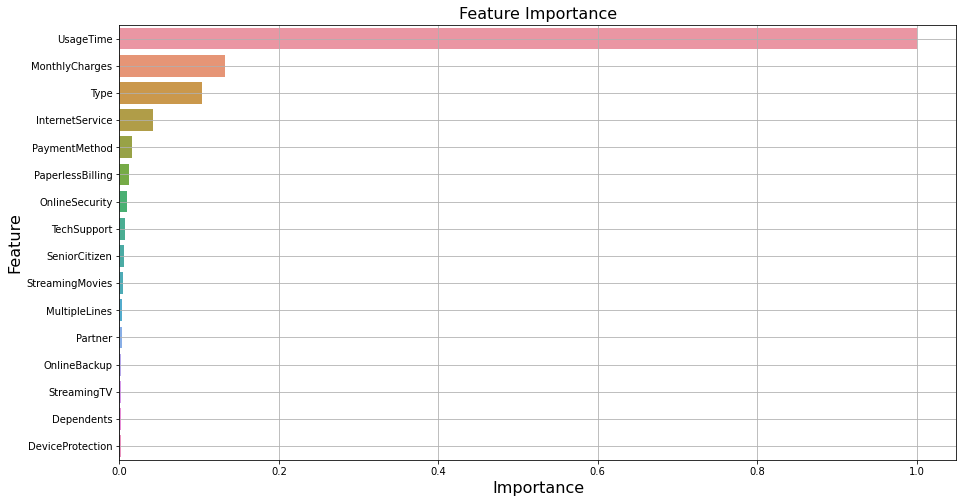

In [65]:
feature_importance = pd.Series(CBC_model_gscv.best_estimator_.feature_importances_,
                               index=x_train_oe.columns)
feature_importance = (feature_importance/feature_importance.max()).sort_values(ascending=False)
plt.figure(figsize=(15,8))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title('Feature Importance', fontsize=16)
plt.xlabel('Importance', fontsize=16)
plt.ylabel('Feature', fontsize=16)
plt.grid()
plt.show()

Наиболее значимым фактором является `UsageTime`. Это значит, что чем дольше клиент пользуется услугами компании, тем меньше вероятность, что он покинет её.

### Тестирование

In [66]:
print("Результат CatBoost на тестовой выборке:")
print('ROC-AUC : {:.2f}'.format(roc_auc_score(y_test,
                                        CBC_model_gscv.best_estimator_.predict_proba(x_test_oe)[:, 1])))
print('Accuracy : {:.2%}'.format(accuracy_score(y_test,
                                                CBC_model_gscv.best_estimator_.predict(x_test_oe))))

Результат CatBoost на тестовой выборке:
ROC-AUC : 0.94
Accuracy : 89.59%


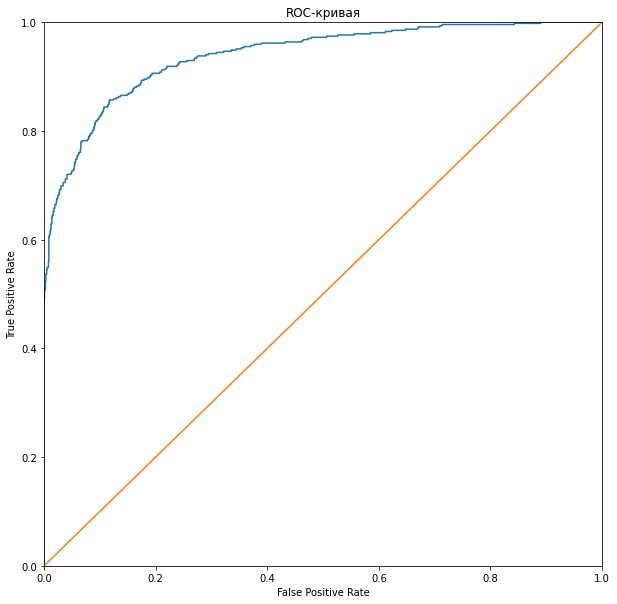

In [67]:
fpr, tpr, thresholds = roc_curve(y_test, CBC_model_gscv.best_estimator_.predict_proba(x_test_oe)[:, 1])

plt.figure(figsize=(10,10))
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='-')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

### Вывод

* Наилучшей моделью из 3х оказалась CatBoost;
* Roc_auc на тестовой выборке получилась равной 0.94;
* Accuracy на тестовой выборке получилась около 90%;
* Были рассмотрены такие модели, как LGBMClassifier, CatBoostClassifier, RandomForrestClassifier. Для каждой модели подбирались гиперпараметры. При подборе наиболее оптимальных параметров модели обучались долго, в среднем по 15-20 минут каждая. Поэтому в итоговом файле применялись только уже наилучшие параметры. Кроме этого, при обучении моделей использовалось GridSeacrh, c кросс-валидацией равной 3. Модель выбиралась по наибольшему значению roc_auc.
* При обучении моделей выборкой, содержаищих разные кодировки, наиболее лучший резльтат показала Ordinal Enconding. Наихудший результат у OneHotEnconding();
* Построен график и таблица значимости каждого фактора. Наиболее значимым фактором оказалось - время (в днях) пользование услугами компании клиентом
* Разница между кодировкой Dummy и OE небольшая, но OE все равно оказался лучше.

## Отчёт

### Выполненные шаги

1) Исследование данных:
* Были загружены датасеты и проверены с помощью метода info();
* Дубликатов и пропусков не обнаружено;
* В датасете `contract` у признаков неправильный тип данных:
 - TotalCharges должен быть float;
 - BeginDate в формате даты;
* В таблицах `phone` и `internet` замечено намного меньше данных, чем в других таблицах.

2) Подготовка данных:
* Были объединены 4 датасета в один большой. В результате этого появились пропуски;
* Пропуски были заменены на `No`, так как это означает, что клиент не пользовался данными услугами;
* Дубликатов не обнаружено;
* В `TotalCharges` были пропуски в результате того, что присутствовали новые люди на момент выгрузки, поэтому данные клиенты были удалены.
* Созданы два новых столбца: бинарный признак ухода клиента и количество дней между заключением договора и его расторжением (или на момент выгрузки, если клиент не ушел);
* Изменены типы данных - `TotalCharges` на float, а признаки с датами на date.

3) Исследовательский анализ данных. В результате было выявлено, что:
* Перестают пользоваться услугами компании те клиенты, у которых месячные траты большие. Данные клиенты уходят в первые месяцы;
* Наиболее используемый метод оплаты - электронный чек;
* Месячная подписка является самой используемой среди клиентов;
* Гендерное распределение сбалансировано;
* Найдена сильная корреляция между общими тратами и времени использования услуг. Что , в целом, логично. Ведь чем дольше клиент пользуется услугами, тем больше он платит.

4) Подготовка признаков для модели:
* Были удалены следующие признакми: Даты BeginDate и EndDate; Gender, customerID - так как не несет полезной информации; TotalCharges - мультиколлинеарный по отношению к UsageTime, что помешает при обучении моделей.
* Датасет был разделен на обучающую и тестовую выборку в соотношении 3:1;
* Категориальные признаки были закодированы с помощью: OneHorEnconding, LabelEnconding,Dummy;
* Произведено масштабирование признаков в тренировочной и тестовой выборке;

5) Модели:
* В качестве моделей были выбраны: {LGBMClassifier, CatBoostClassifier, RandomForrestClassifier}.
* В качестве гиперпараметров осуществлялся подбор по таким пунктам, как: 
 - Learning rate: [0.1,0.2,0.3];
 - max_depth: range(1,10)
* В результате обучения для каждой модели были подобраны свои гиперпараметры.
* Модели были обучены на обучающих выборках с разными способами кодирования признаков. По результатам было выявлено, что лучшая модель получилась  CatBoost с кодировкой данных Ordinal Enconding. Наихудша модель у LGBMClassifier с кодировкой OneHotEnconding. Кроме этого, хорошо показала себя модель CatBoost с кодировкой Dummy.
* У лучшей модели roc_auc получилась равной `0.9314`. Параметры данной модели: 
  - max_depth = 2
  - learning_rate = 0.3
  - n_estimators = 800
* По результатам модели было построена таблица и график важности признаков. Наиболее значимым признаком оказалось время пользования услугами компании в днях (UsageTime)

6) Проверка лучшей модели на тестовой выборке:
* Результат CatBoost на тестовой выборке:
  - ROC-AUC : 0.94
  - Accuracy : 89.59%
* Данный результат модели оказался очень хорошим. Можно использовать данную модель в дальнейшей работе компании.

### Трудности

* Больше всего времени занело обучение моделей. Это скорее не трудность, а особенность. Так как для каждой модели необходимо было подбирать индивидуальные гиперпараметры.
* Использование нового способа кодировки -  OneHotEnconding. Так как остальные методы выводят таблицу с закодироваными признакми. а OneHotEnconding преобразует признаки в матрицу. И было трудно понять, правильно ли отработал метод.

### Ключевые шаги в решении задачи

* Составление плана. Это помогает поэтапно выполнять поставленную задачу;
* Обработка данных и добавление новых признаков. Как показал результат, наиболее значимым признаком оказался как раз новый признак - `UsageTime`;
* Исследовательский анализ данных. Данный анализ помогает найти закономерности в поведении клиентов в компании без использования машинного обучения и дать некоторые рекомендации заказчику и найти корреляции между признаками;
* Подготовка данных для обучения. Ведь от качества подготовки данных будет зависеть дальнейшое обучение моделей и их качество;
* Обучение и анализ различных моделей. 

### Итоговая модель

По итогам проведенного анализа и обучения, было выявлено - что лучшая модель `CatBoost`.
* Параметры данной модели: 
  - max_depth = 2
  - learning_rate = 0.3
  - n_estimators = 800
* По результатам проверки на тестовой выборке получились следующие значения:
  - roc_auc = 0.9314
  - accuracy = 90%